# Prey predator braitenberg notebook

This notebook showcases how to add new features on top on a pre-existing vivarium environment. Here, we will focus on implementing a prey predator braitenberg environment !

## Imports

First, let's import Classes and functions from the environment you want to build features on, as well as standard jax elements to build new features in our environment.

In [1]:
from enum import Enum
from functools import partial
from typing import Tuple

import numpy as np
import jax.numpy as jnp

from jax import vmap, jit
from jax_md.dataclasses import dataclass as md_dataclass

from vivarium.environments.braitenberg.simple.simple_env import BraitenbergEnv
from vivarium.environments.braitenberg.simple.classes import AgentState, State, EntityType
from vivarium.environments.braitenberg.simple.init import init_complete_state, init_entities, init_objects
from vivarium.environments.braitenberg.simple.simple_env import compute_motor, compute_prox
from vivarium.environments.braitenberg.behaviors import behavior_to_params, Behaviors

### Define the states classes of prey predator env 

Define the new classes and constants of the environment. We will just add a new field agent_type (prey or predator) for all of our agents, so whe can differenciate them when we run the simulation.

In [2]:
class AgentType(Enum):
    PREY = 0
    PREDATOR = 1

@md_dataclass
class AgentState(AgentState):
    agent_type: jnp.array

### Create the new state

First we'll create a new state for the prey predator environment. It will be pretty similar to the one of the simple braitenberg env, but we will just add a new field agent_type to our agents. Additionally, we'll use different colors and behaviors for the prey and predators.

In [3]:
# parameter values
n_preys = 25
n_predators = 25
max_agents = n_preys + n_predators
pred_eating_range = 10

box_size = 200
wheel_diameter = 2.0
speed_mul = 1.0
max_speed = 10.0
theta_mul = 1.0
prox_dist_max = 40.0
prox_cos_min = 0.0
box_size = 200
max_obj = 25

prey_color = jnp.array([0.0, 0.0, 1.0])
predator_color = jnp.array([1.0, 0.0, 0.0])
objects_color = jnp.array([0., 1., 0.])

In [4]:
# construct fields for our agents dataclass
np_behaviors = np.hstack((np.full(n_preys, Behaviors.FEAR.value), np.full(n_predators, Behaviors.AGGRESSION.value)))
params = jnp.array([behavior_to_params(behavior) for behavior in np_behaviors])
behaviors = jnp.array(np_behaviors)
agent_types = jnp.hstack((jnp.full(n_preys, AgentType.PREY.value), jnp.full(n_predators, AgentType.PREDATOR.value)))
agents_colors = jnp.concatenate((jnp.tile(prey_color, (n_preys, 1)), jnp.tile(predator_color, (n_predators, 1))), axis=0)

agents = AgentState(
    # idx in the entities (ent_idx) state to map agents information in the different data structures
    ent_idx=jnp.arange(max_agents, dtype=int),
    agent_type=agent_types, 
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=behaviors,
    params=params,
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    proximity_map_dist=jnp.zeros((max_agents, 1)),
    proximity_map_theta=jnp.zeros((max_agents, 1)),
    color=agents_colors
    )

# create entities and objects with helper functions
entities = init_entities(max_agents=max_agents, max_objects=max_obj, box_size=box_size)
objects = init_objects(max_objects=max_obj, objects_color=objects_color)

# create the final state with all the elements
state = init_complete_state(
    entities=entities,
    agents=agents,
    objects=objects,
    box_size=box_size,
    max_agents=max_agents,
    max_objects=max_obj
)

### Define prey predator env class 

Now that we created our new state, we need to create the environment class where we'll implement the logic of the simulation. It will inherit from the simple Braitenberg env, so we will only have to overwrite a few methods and create some new ones to make our prey predator environment. 

First, we need to overwrite the \_\_init__() function to allow specifying new parameters about preys and predators (the pred_eating_range in our case).

Finally, we just have to write functions to implement our new desired features (here the predators will kill the preys next to them), and add them in the _step() function !

In [5]:
class PreyPredBraitenbergEnv(BraitenbergEnv):
    def __init__(
            self,
            state,
            pred_eating_range
    ):  
        super().__init__(state=state)
        # Add idx utils to simplify conversions between entities and agent states
        self.agents_idx = jnp.where(state.entities.entity_type == EntityType.AGENT.value)
        self.prey_idx = jnp.where(state.agents.agent_type == AgentType.PREY.value)
        self.pred_idx = jnp.where(state.agents.agent_type == AgentType.PREDATOR.value)
        self.pred_eating_range = pred_eating_range

    # Add a function to detect if a prey will be eaten by a predator in the current step
    def can_all_be_eaten(self, R_prey, R_predators, predator_exist):
        # Could maybe create this as a method in the class, or above idk
        distance_to_all_preds = vmap(self.distance, in_axes=(None, 0))

        # Same for this, the only pb is that the fn above needs the displacement arg, so can't define it in the cell above 
        def can_be_eaten(R_prey, R_predators, predator_exist):
            dist_to_preds = distance_to_all_preds(R_prey, R_predators)
            in_range = jnp.where(dist_to_preds < self.pred_eating_range, 1, 0)
            # Could also return which agent ate the other one (e.g to increase their energy) 
            will_be_eaten_by = in_range * predator_exist
            eaten_or_not = jnp.where(jnp.sum(will_be_eaten_by) > 0., 1, 0)
            return eaten_or_not
        
        can_be_eaten = vmap(can_be_eaten, in_axes=(0, None, None))
        
        return can_be_eaten(R_prey, R_predators, predator_exist)
    
    # Add functions so predators eat preys
    def eat_preys(self, state):
        # See which preys can be eaten by predators and update the exists array accordingly
        R = state.entities.position.center
        exist = state.entities.exists
        prey_idx = self.prey_idx
        pred_idx = self.pred_idx

        agents_ent_idx = state.agents.ent_idx
        predator_exist = exist[agents_ent_idx][pred_idx]
        can_be_eaten_idx = self.can_all_be_eaten(R[prey_idx], R[pred_idx], predator_exist)

        # Kill the agents that are being eaten
        exist_prey = exist[agents_ent_idx[prey_idx]]
        new_exists_prey = jnp.where(can_be_eaten_idx == 1, 0, exist_prey)
        exist = exist.at[agents_ent_idx[prey_idx]].set(new_exists_prey)

        return exist

    # Add the eat_preys function in the _step loop
    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors: jnp.array, agents_neighs_idx: jnp.array) -> Tuple[State, jnp.array]:
        # 1 Compute which agents are being eaten
        exist = self.eat_preys(state)
        entities = state.entities.set(exists=exist)

        # 2 Compute the proximeter of agents
        exists_mask = jnp.where(entities.exists == 1, 1, 0)
        prox, proximity_dist_map, proximity_dist_theta = compute_prox(state, agents_neighs_idx, target_exists_mask=exists_mask, displacement=self.displacement)
        motor = compute_motor(prox, state.agents.params, state.agents.behavior, state.agents.motor)
        agents = state.agents.set(
            prox=prox, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=motor
        )

        # 3 Update the state with the new agent and entities states
        state = state.set(
            agents=agents,
            entities=entities
        )

        # 4 Apply physics forces to the environment state
        entities = self.apply_physics(state, neighbors)
        state = state.set(
            time=state.time+1,
            entities=entities,
        )

        # 5 Update the neighbors according to the new positions
        neighbors = neighbors.update(state.entities.position.center)
        return state, neighbors

### Create env and render its state

We define the colors in our environment this way: 

- Prey agents: blue
- Predator agents: red
- Objects: green

In [6]:
from vivarium.environments.braitenberg.render import render, render_history

In [7]:
env = PreyPredBraitenbergEnv(
    state=state,
    pred_eating_range=pred_eating_range
)

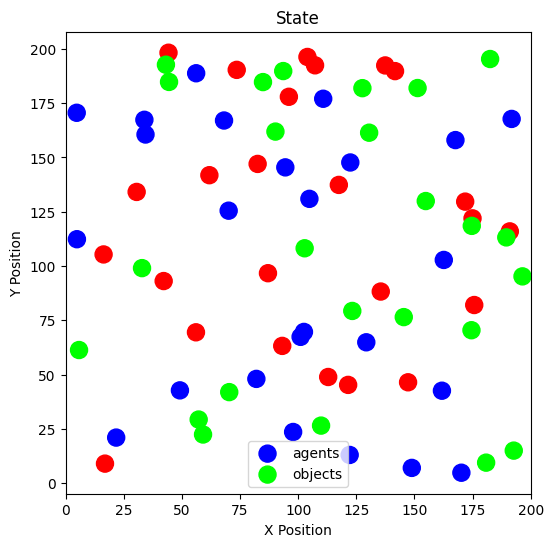

In [8]:
render(state)

### Run a simulation on a few timesteps

In [9]:
n_steps = 2000

hist = []
for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

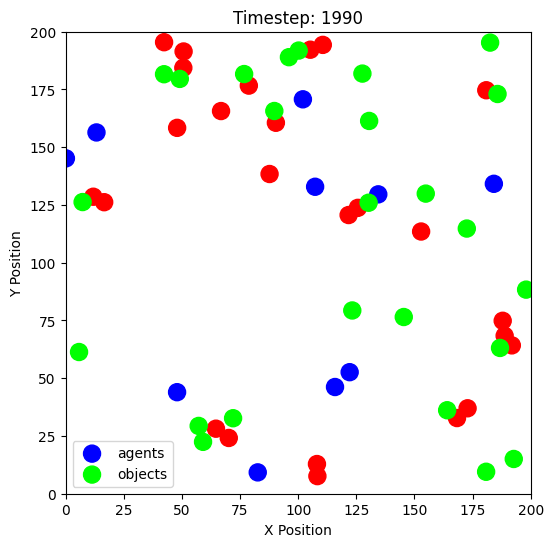

In [10]:
render_history(hist, skip_frames=10)

The rendering function is quite laggy, but we can see that prey agents are now being eaten by predator ones ! 